# Hi!

This notebooks presents a guide for autoencoding songs with the AE-NTD method, presented in [1, Chap 6].

It presents a simple example (Come Together, from The Beatles), and present the outputs of each compression method (NTD and AE-NTD with both Random and NTD Init decoders) on the Nonnegative Log Mel spectrogram.

For patterns with better audio quality, you should swith to STFT representation (at the expense of larger computation costs). In this example, patterns are indeed... very noisy. 

**This notebook must be seen as a code demonstrator rather than a Proof of Concept.**

Feel free to play with this code! (like changing the song, the parameters, digging into the code, etc)

# References

[1] Marmoret, A. (2022). Unsupervised Machine Learning Paradigms for the Representation of Music Similarity and Structure (Doctoral dissertation, Université Rennes 1). https://theses.hal.science/tel-04589687

# Imports

In [1]:
# External imports
# Module for manipulating arrays
import numpy as np

# Module for reading signals
import librosa

# Pytorch, for neural networks
import torch

# Module to handle annotations for MIR files
import mirdata

# Module to manipulate tensors, used here to unfold/fold tensors.
import tensorly as tl

# Copy is important to obtain a reconstruction object for the feature
import copy

In [2]:
# Module encapsulating the computation of features from the signal
import barmuscomp.model.signal_to_spectrogram as signal_to_spectrogram

# Module encapsulating the computation of signal from the factorisation outputs
import barmuscomp.model.factorisation_to_signal as factorisation_to_signal

# General module for manipulating data: conversion between time, bars, frame indexes, loading of data, ...
import as_seg.data_manipulation as dm

# Module to process the input in barwise features
import as_seg.barwise_input as bi

# Module containing our algorithm used for computing the autosimilarity
import as_seg.autosimilarity_computation as as_comp

# Module containing our algorithm used for segmenting the autosimilarity
import as_seg.CBM_algorithm as CBM

# Module encapsulating Low-rank approximations (for NTD)
import barmuscomp.lra as lra

# Module defining our neural network (CNN AutoEncoder)
import barmuscomp.ae_ntd as ae_ntd

# Module for data manipulation related to neural networks
import barmuscomp.ae_utils as ae_utils

# Plotting module
from barmuscomp.model.common_plot import *

# Audio helper
import base_audio.audio_helper as audio_helper

# Loading the song, its annotations, and preparing it

Now, let's load the song (as a wav).

If you want to test in our example (Come Together, from the Beatles), you'll need to load the wav from your PC, but the rest of the data (like the annotations) will be downloaded automatically thanks to the package `mirdata`!

In that case, you need to modify the variable `path_to_beatles_dataset`, specifying where you want Betales annotation to be downloaded, and place the wav "01_-\_Come_Together.wav" in the folder "audio/11_-\_Abbey_Road/".

If you want to test on your own example, you'll need to change the variable `song_path`, and load manually your annotations (or no annotation at all if you don't need to test on the segmentation task and just visualize results).

In [4]:
path_to_beatles_dataset = '/home/a23marmo/datasets/beatles'
beatles = mirdata.initialize('beatles', path_to_beatles_dataset)
beatles.download()

# NB: you have to place the file "01_-_Come_Together.wav" manually in the folder "audio/11_-_Abbey_Road/"
come_together = beatles.track('1101')

references_segments = beatles.load_sections(come_together.sections_path).intervals

song_path = come_together.audio_path

INFO: Downloading ['annotations'] to /home/a23marmo/datasets/beatles
INFO: [annotations] downloading The Beatles Annotations.tar.gz
INFO: /home/a23marmo/datasets/beatles/annotations/The Beatles Annotations.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: 
    Unfortunately the audio files of the Beatles dataset are not available
    for download. If you have the Beatles dataset, place the contents into
    a folder called Beatles with the following structure:
        > Beatles/
            > annotations/
            > audio/
    and copy the Beatles folder to /home/a23marmo/datasets/beatles

/tmp/ipykernel_37761/842705813.py:8: DeprecationWarning: Call to deprecated method load_sections. (Use mirdata.datasets.beatles.load_sections) -- Deprecated since version 0.3.4.
  references_segments = beatles.load_sections(come_together.sections_path).intervals


Loading the song as signal, and estimating bars of this song (using the `madmom` external library).

In [6]:
the_signal, sampling_rate = librosa.load(song_path)
bars = dm.get_bars_from_audio(song_path)

/home/a23marmo/environnements_venv/msa/lib/python3.10/site-packages/madmom/io/audio.py:643: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


# Spectrogram
Let's compute the spectrogram of the song. We propose either the Mel Spectrorgram or the Nonnegative Log Mel Spectrogram in this code, but you can chose any other feature (either on the file `features.py`, or by looking at the list on the `librosa` package).

In [7]:
# Variables for the tensor-spectrogram.
hop_length = 32 # Oversampling the spectrogram, to select frames which will be equally-spaced barwise.

subdivision_bars = 96 # Number of frame per bar in the tensor-spectrogram
median_hop = dm.get_median_hop(bars, subdivision = subdivision_bars, sampling_rate = sampling_rate) #For audio reconstruction

# Mel Spectrogram
# feature_object = signal_to_spectrogram.FeatureObject(sr = sampling_rate, feature="mel", hop_length = hop_length, mel_grill = True)
# NN Log Mel Spectrogram
feature_object = signal_to_spectrogram.FeatureObject(sr = sampling_rate, feature="nn_log_mel", hop_length = hop_length, mel_grill = True) # Audio outputs are aweful when using nn_log_mel

reconstruction_feature_object = copy.deepcopy(feature_object)
reconstruction_feature_object.hop_length = median_hop

spectrogram = feature_object.get_spectrogram(the_signal)


/home/a23marmo/environnements_venv/msa/lib/python3.10/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


We then form the associated tensors-spectrograms:

In [8]:
#For NTD
tensor_spectrogram_ftb = bi.tensorize_barwise_FTB(spectrogram, bars, hop_length / sampling_rate, subdivision_bars)
#For the AE
tensor_spectrogram_bft = bi.tensorize_barwise_BFT(spectrogram, bars, hop_length / sampling_rate, subdivision_bars)

# NTD
Now, let's compute the NTD on this song.

In [9]:
ntd_dimensions = [24,12,12]
core, factors = lra.ntd_computation(tensor_spectrogram_ftb, ntd_dimensions, beta = 2, init = "tucker")

/home/a23marmo/environnements_venv/msa/lib/python3.10/site-packages/numpy/lib/function_base.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


Evaluating the NTD through its autosimilarity:

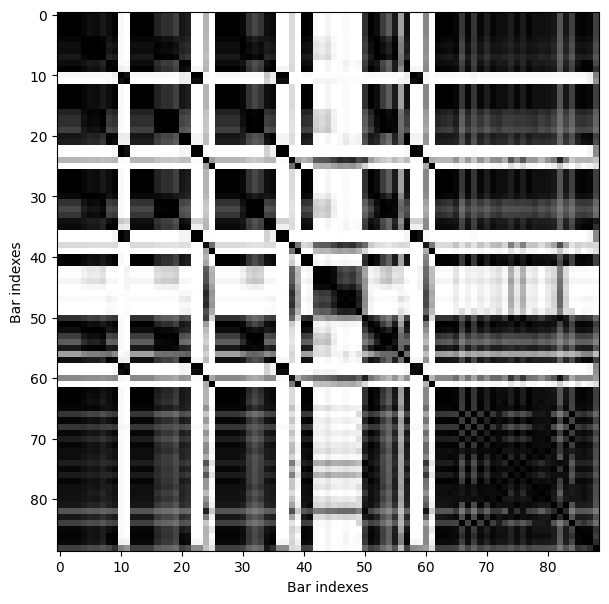

In [10]:
autosimilarity_ntd = as_comp.switch_autosimilarity(factors[2], similarity_type = "cosine", normalise = True)
plot_me_this_spectrogram(autosimilarity_ntd, x_axis = "Bar indexes", y_axis = "Bar indexes", title = None)#"Autosimilarity of Q")

Plotting outputs of the decomposition, for comparison with AE-NTD later:

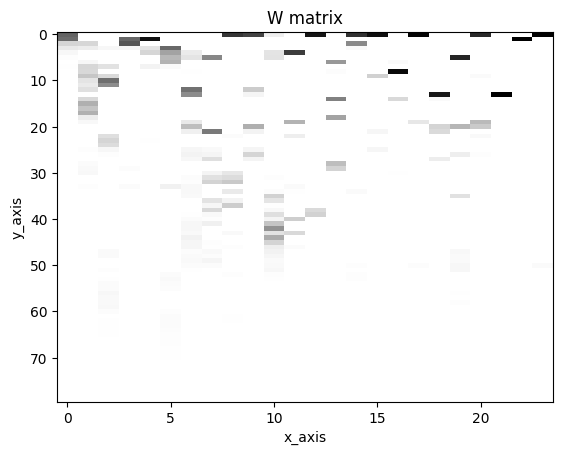

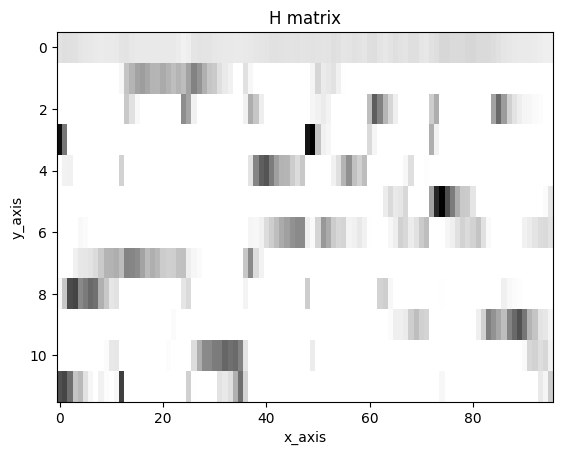

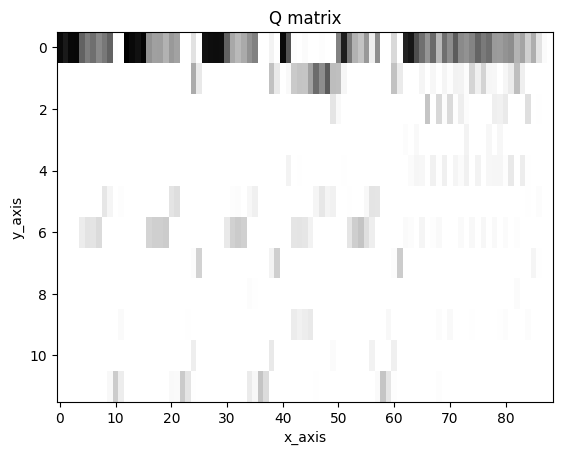

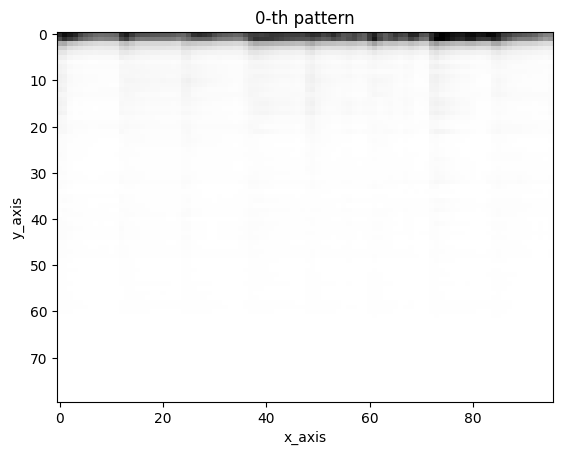

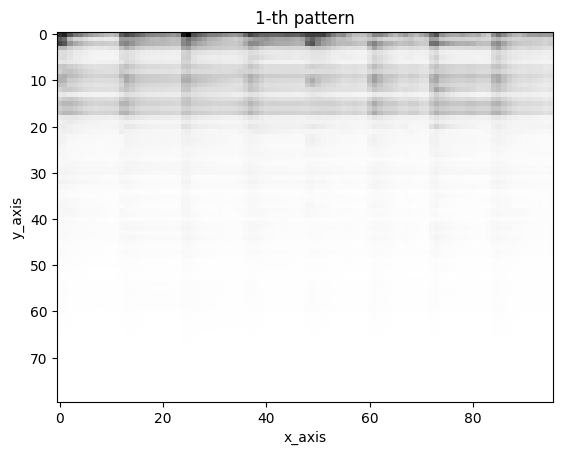

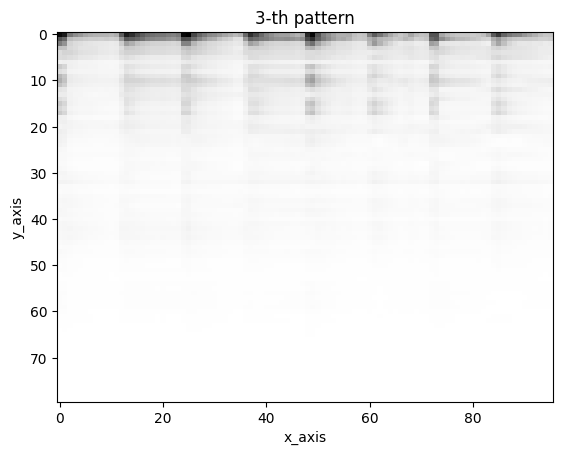

In [17]:
plot_me_this_spectrogram(factors[0], title = "W matrix")
plot_me_this_spectrogram(factors[1].T, title = "H matrix")
plot_me_this_spectrogram(factors[2].T, title = "Q matrix")

pattern_list_NTD = factorisation_to_signal.compute_patterns_from_NTD(core, factors[0], factors[1])

for i in range(4): #Only 4 patterns (for simplicity)
    plot_me_this_spectrogram(pattern_list_NTD[i], title = f"{i}-th pattern")
    audio = factorisation_to_signal.get_pattern_signal_from_NTD(factors[2], pattern_list_NTD, pattern_idx=i, feature_object = reconstruction_feature_object, phase_retrieval = "griffin_lim")
    audio_helper.listen_to_this_signal(audio, sr=sampling_rate)

# AE-NTD
Let's now evaluate AE-NTD on this song. First, let's compute the data_loader, the PyTorch way to handle our tensor-spectrogram.

In [12]:
data_loader = ae_utils.generate_dataloader(tensor_spectrogram_bft, batch_size = None)

## Random Decoder
Let's start with the decoder initialized at random, and show the evolution of the loss function with the epochs.

In [13]:
random_decoder = ae_ntd.ConvolutionalAutoencoderNTD(input_size_x = subdivision_bars, input_size_y = spectrogram.shape[0], 
                                                    ntd_dimensions = ntd_dimensions, unfolded_G = None, W = None, H = None,
                                                    bn_latent_init_stds = None, bn_latent_init_avgs = None,beta = 2, seed = 42)
random_decoder, losses = random_decoder.my_optim_method(1000, data_loader, verbose = False, lr = 1e-3)
print(f"Final reconstruction error: {losses[-1]}")
plt.plot(losses)
plt.title("Reconstruction error with iterations")
plt.legend(["Reconstruction error"])
plt.yscale('log')
plt.show()

/home/a23marmo/environnements_venv/msa/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Final reconstruction error: 6.6129865646362305


Now, let's observe the outputs:

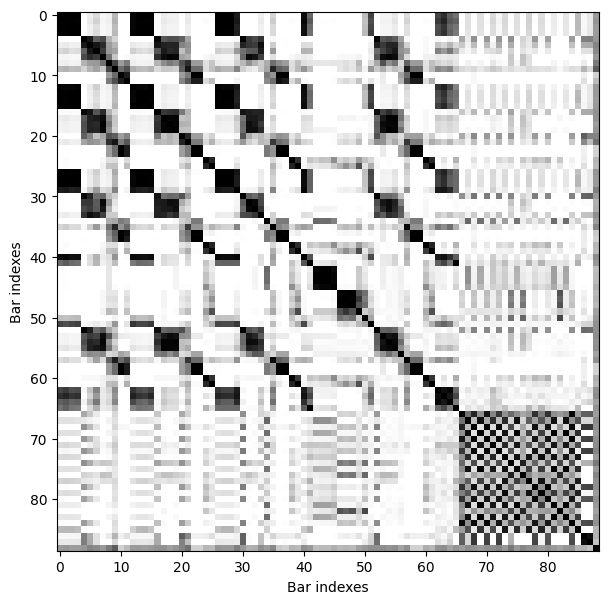

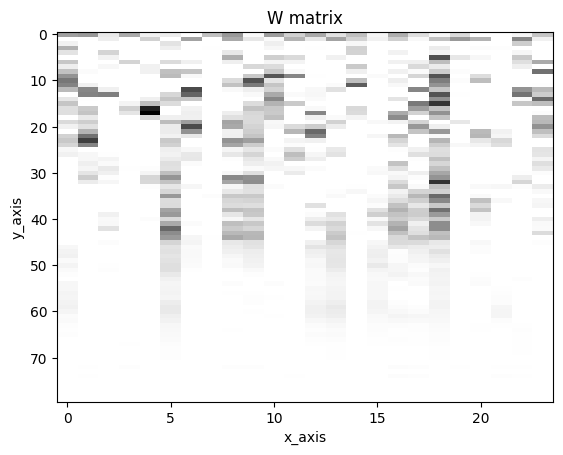

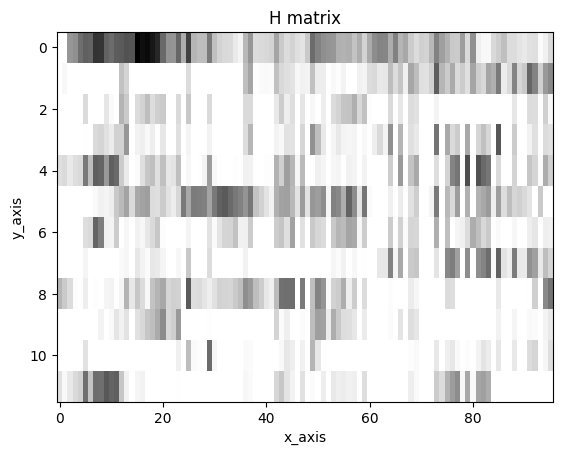

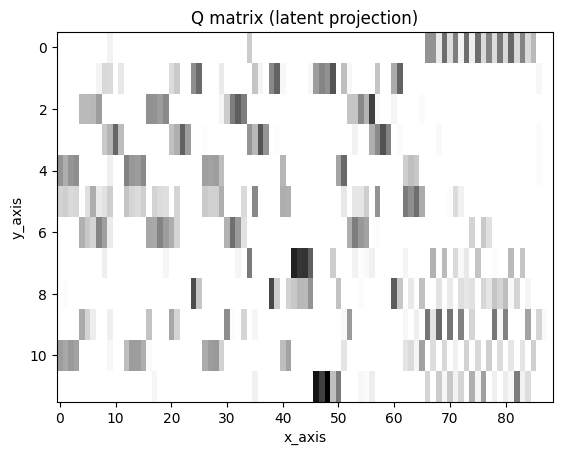

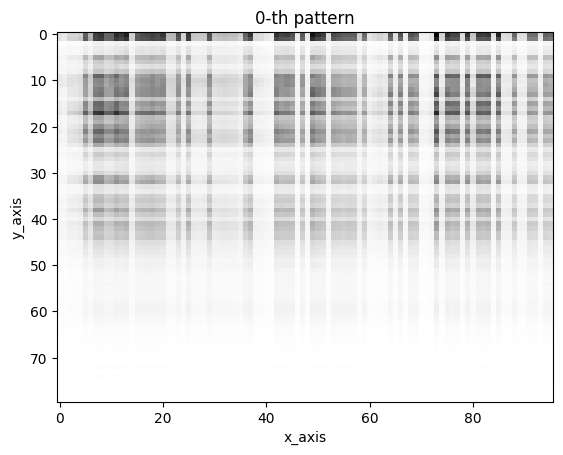

/home/a23marmo/environnements_venv/msa/lib/python3.10/site-packages/librosa/feature/inverse.py:99: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


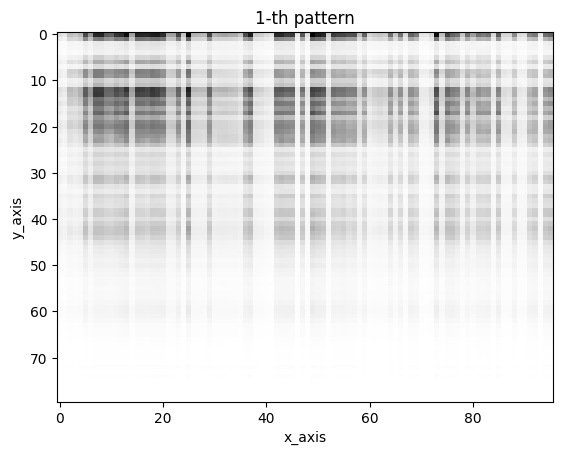

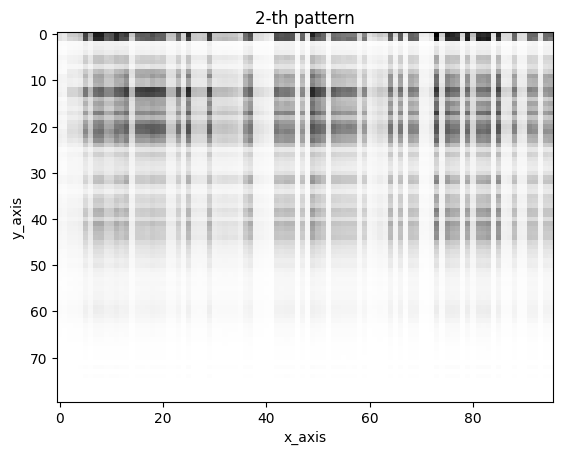

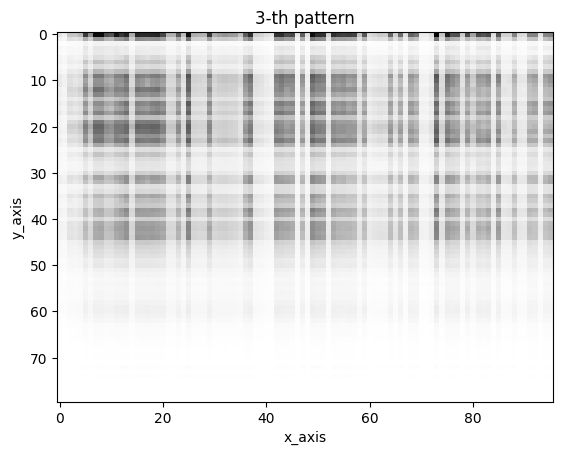

In [14]:
autosimilarity_random_ae = as_comp.switch_autosimilarity(random_decoder.get_latent_projection(data_loader), similarity_type = "cosine", normalise = True)
plot_me_this_spectrogram(autosimilarity_random_ae, x_axis = "Bar indexes", y_axis = "Bar indexes", title = None)#"Autosimilarity of Q")

plot_me_this_spectrogram(random_decoder.get_W(), title = "W matrix")
plot_me_this_spectrogram(random_decoder.get_H().T, title = "H matrix")
plot_me_this_spectrogram(np.array(random_decoder.get_latent_projection(data_loader)).T, title = "Q matrix (latent projection)")

pattern_list_AE_NTD_rand = factorisation_to_signal.compute_patterns_from_NTD(random_decoder.get_G(), random_decoder.get_W(), random_decoder.get_H())

for i in range(4): #Only 4 patterns (for simplicity)
    plot_me_this_spectrogram(pattern_list_AE_NTD_rand[i], title = f"{i}-th pattern")
    audio = factorisation_to_signal.get_pattern_signal_from_NTD(np.array(random_decoder.get_latent_projection(data_loader)), pattern_list_AE_NTD_rand, pattern_idx=i, feature_object = reconstruction_feature_object, phase_retrieval = "griffin_lim")
    audio_helper.listen_to_this_signal(audio, sr=sampling_rate)

## NTD initialized decoder
As a second avauation, let's compare the previous outputs with a NTD-initialized decoder:

/home/a23marmo/environnements_venv/msa/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Final reconstruction error: 1.5732558965682983


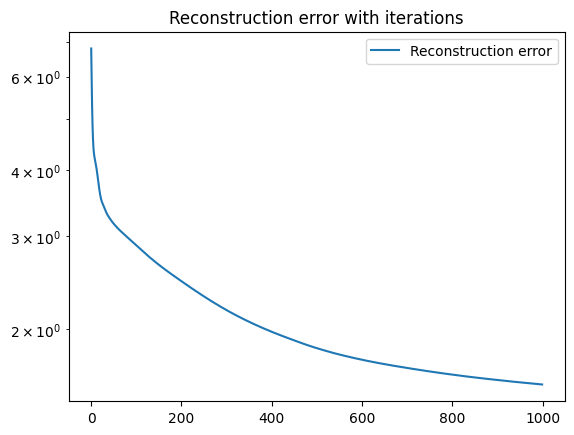

In [15]:
bn_latent_init_stds = [np.std(factors[2][:,i]) for i in range(factors[2].shape[1])]
bn_latent_init_avgs = [np.mean(factors[2][:,i]) for i in range(factors[2].shape[1])]

ntd_init_decoder = ae_ntd.ConvolutionalAutoencoderNTD(input_size_x = subdivision_bars, input_size_y = spectrogram.shape[0], 
                                                      ntd_dimensions = ntd_dimensions, unfolded_G = tl.unfold(core, 2),
                                                      W = factors[0], H = factors[1],
                                                      bn_latent_init_stds = bn_latent_init_stds, bn_latent_init_avgs = bn_latent_init_avgs,beta = 2, seed = 42)
ntd_init_decoder, losses = ntd_init_decoder.my_optim_method(1000, data_loader, verbose = False, lr = 1e-3)
print(f"Final reconstruction error: {losses[-1]}")
plt.plot(losses)
plt.title("Reconstruction error with iterations")
plt.legend(["Reconstruction error"])
plt.yscale('log')
plt.show()

Now, let's observe the outputs:

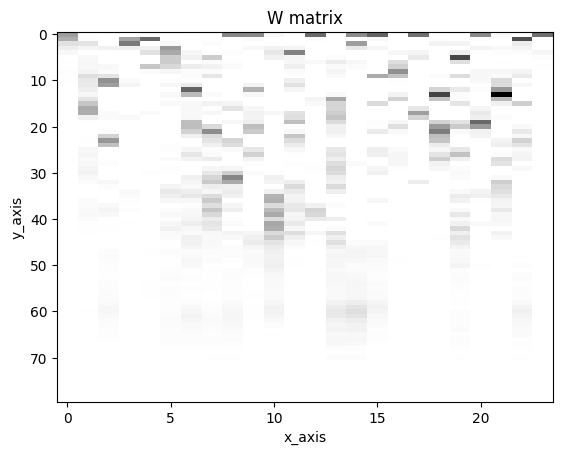

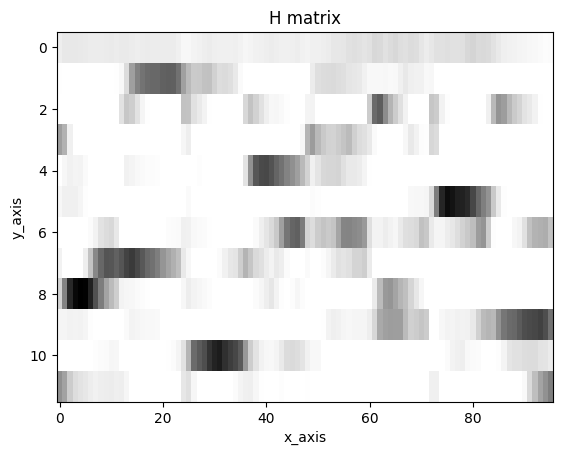

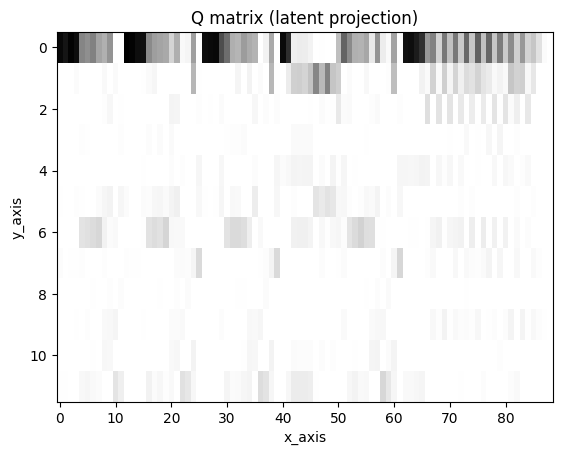

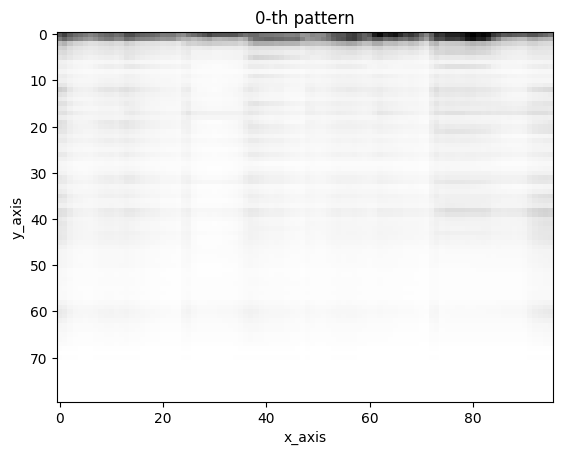

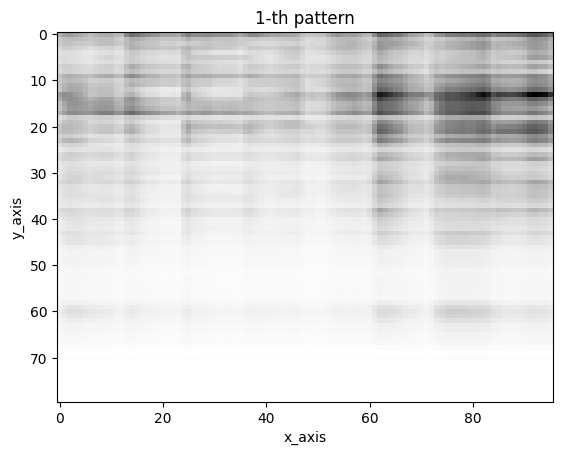

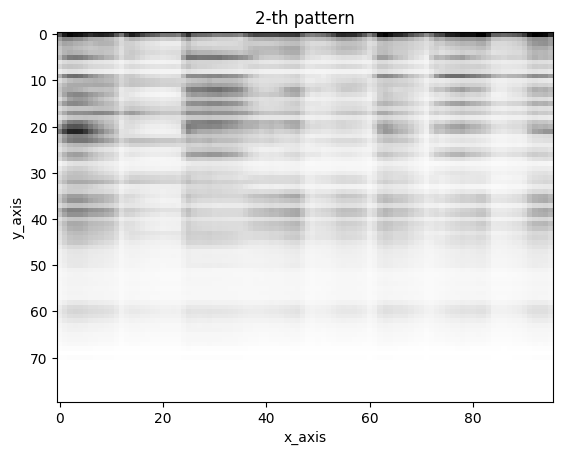

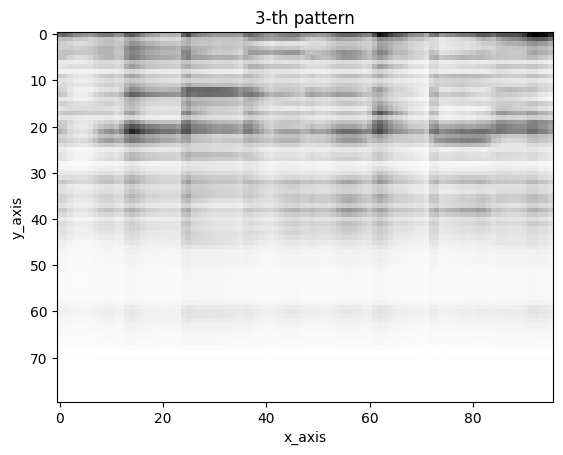

In [16]:
autosimilarity_ntd_init_ae = as_comp.switch_autosimilarity(ntd_init_decoder.get_latent_projection(data_loader), similarity_type = "cosine", normalise = True)
plot_me_this_spectrogram(autosimilarity_ntd_init_ae, x_axis = "Bar indexes", y_axis = "Bar indexes", title = None)#"Autosimilarity of Q")

plot_me_this_spectrogram(ntd_init_decoder.get_W(), title = "W matrix")
plot_me_this_spectrogram(ntd_init_decoder.get_H().T, title = "H matrix")
plot_me_this_spectrogram(np.array(ntd_init_decoder.get_latent_projection(data_loader)).T, title = "Q matrix (latent projection)")

pattern_list_AE_NTD_init = factorisation_to_signal.compute_patterns_from_NTD(ntd_init_decoder.get_G(), ntd_init_decoder.get_W(), ntd_init_decoder.get_H())

for i in range(4): #Only 4 patterns (for simplicity)
    plot_me_this_spectrogram(pattern_list_AE_NTD_init[i], title = f"{i}-th pattern")
    audio = factorisation_to_signal.get_pattern_signal_from_NTD(np.array(ntd_init_decoder.get_latent_projection(data_loader)), pattern_list_AE_NTD_init, pattern_idx=i, feature_object = reconstruction_feature_object, phase_retrieval = "griffin_lim")
    audio_helper.listen_to_this_signal(audio, sr=sampling_rate)